# Assignment 5

**Submission deadline:**

**Problems 1 and 2 last lab session before or on Wednesday, 13.12.17**

**Problems 3 and bonuses last lab session before or on Wednesday, 20.12.17**

**Points: 10 + 4 bonus points**


## Downloading this notebook

This assignment is an Jupyter notebook. Download it by cloning https://github.com/janchorowski/nn_assignments. Follow the instructions in its README for instructions.

Please do not hesitate to use GitHub’s pull requests to send us corrections!

In [1]:
# Common imports

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Torch has to go first due to an importing bug
import torch

import collections

import numpy as np
import scipy.io
import scipy.ndimage

import re

import PIL

import logging
logging.getLogger("PIL").setLevel(logging.INFO)

from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision

import common.plotting

In [3]:
import os
os.environ['PYTORCH_DATA_PATH'] =  "/pio/data/data/torchvision"
os.environ['TORCH_MODEL_ZOO'] =  os.environ['PYTORCH_DATA_PATH']
print (os.environ['TORCH_MODEL_ZOO'])
#"/pio/data/data/torchvision" #os.environ.get('PYTORCH_DATA_PATH')

/pio/data/data/torchvision


In [4]:
# We strongly recommend training using CUDA on lab computers
CUDA = False

def to_np(x):
    if isinstance(x, Variable):
        x = x.data
    return x.cpu().numpy()

def to_variable(x, **kwargs):
    x = torch.from_numpy(x)
    if CUDA:
        x = x.cuda()
    return Variable(x, **kwargs)

# Problem 1: Understanding the VGG network [4p]

In this task we will load a pre-trained model of the [VGG network](http://www.robots.ox.ac.uk/~vgg/research/very_deep/). It's a convolutional network developed at the Oxford University, trained on the [Imagenet Large Scale Visual Recognition Challenge 2012 (ILSVRC2012)](http://image-net.org/challenges/LSVRC/2012/) classificatiom dataset of 1.2 million training images of 1000 classes. A few VGG models of different depth have been proposed. The diagram below presents VGG16. Details of those models: [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556) by Simonyan and Zisserman.

![vgg16](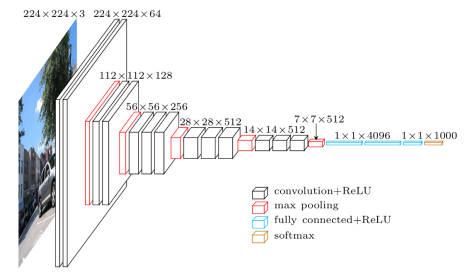
)

We will investigate how VGG classifies images, and 
try to build a deeper understanding of which parts of
a particular input image influence the output of the network.
We will start by simply occluding parts of the image
with a square of zeros anchored at point $(i, j)$ ,
and analyzing how the signal propagated through the network changes.
Becuase pre-processing for VGG requires to subtract the mean,
the most neutral occluding squares will appear grey when pre-processing is reversed.
Further reading: [Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)
by Zeiler and Fergus.

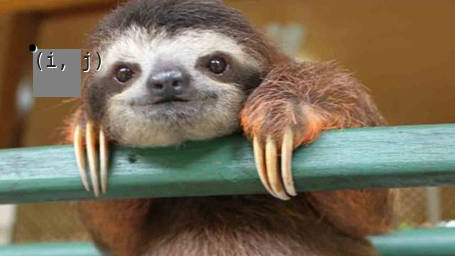

Let $X^{L:m}_{(k,l)}$ denote the input image tensor procesed by 
the $m$-th map of layer $L$,
where $(k, l)$ denote position in the map. To complete the assignment:
1. **[1p]** Load a pre-trained model of a VGG network (e.g., VGG-19) and inspect its architecture.
  Classify at least 5 images of your
  choice and plot them along with top-5 predictions returned by the network. We provide a mapping from
  numerical class labels to textual descriptions.
  It is vital to apply the same pre-processing as the one which has been used during network training.
2. **[2p]** Implement and test heatmaps generated by iteratively occluding parts of the input image.
  * Implement a data iterator which takes an input image and iteratively occludes part of the image with a
    rectangle (see sample image above).
  * Implement a function `layer_activations(x, layer_name)` of
    the VGG network class,
    which taps into the network and returns activations of a chosen layer. 
    For each occluding position $(i, j)$ in the input image, we can record 
    sum of activations of feature map $m$ in layer $L$ as a heatmap
    $h^{L:m}_{(i,j)} = \sum_{k,l} X^{L:m}_{(k,l)}$. Moving around the occluding rectangle
    changes the activations. Plot heatmaps $h^{L:m}$ for
    a few selected layers and images.
  * For each occluding position $(i, j)$ in the input image, we can record
    output probability of the true class $C$ and store it as $p(C|i,j)$.
    Plot such probability maps for a few images. Plot maps of network predictions
    $\text{argmax}_c p(c|i,j)$, which should reveal which occluding positions
    change the prediction of the network.
3. **[1p]** The method of [Integrated Gradients](https://arxiv.org/abs/1703.01365)
    allows to track which input pixels influence predictions of the network.
    Complete the code and run the method on a couple of examples.

In [5]:
class ILSVRC2014Sample(object):
    """Mapper from numerical class IDs to their string LABELS and DESCRIPTIONS.
    
    Please use the dicts:
    - id_to_label and label_to_id to convert string labels and numerical ids
    - label_to_desc to get a textual description of a class label
    - id_to_desc to directly get descriptions for numerical IDs
    
    """
    def load_image(self, path):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        for t in self.transforms:
            img = t(img)
        return numpy.asarray(img).astype('float32') / 255.0
    
    def __init__(self, num=100):
        self.transforms = [
            torchvision.transforms.Scale(256),
            torchvision.transforms.CenterCrop(224)]
        
        base_dir = os.environ['PYTORCH_DATA_PATH'] + '/ILSVRC2014'
        devkit_dir = base_dir + '/ILSVRC2012_devkit_t12/data'
        
        meta = scipy.io.loadmat(devkit_dir + '/meta.mat')
        imagenet_class_names = []
        self.label_to_desc = {}
        for i in range(1000):
            self.label_to_desc[meta['synsets'][i][0][1][0]] = meta['synsets'][i][0][2][0]
            imagenet_class_names.append(meta['synsets'][i][0][1][0])
            
        img_names = sorted(os.listdir(base_dir + '/ILSVRC2012_img_val'))[:num]
        img_ids = {int(re.search('\d{8}', name).group()) for name in img_names}
        with open(devkit_dir + '/ILSVRC2012_validation_ground_truth.txt', 'r') as f:
            self.labels = [imagenet_class_names[int(line.strip()) - 1] \
                           for i, line in enumerate(f) if i+1 in img_ids]
        self.data = [self.load_image(base_dir + '/ILSVRC2012_img_val/' + name)
                     for name in img_names]
        
        self.id_to_label = sorted(self.label_to_desc.keys())
        self.label_to_id = {}
        self.id_to_desc = []
        for id_, label in enumerate(self.id_to_label):
            self.label_to_id[label] = id_
            self.id_to_desc.append(self.label_to_desc[label])

In [6]:
#
# TODO: fill in the blanks in the VGG network. The function multi_layer_activations
# is only needed for the last homework.
#



class VGGPreprocess(torch.nn.Module):
    """Pytorch module that normalizes data for a VGG network
    """
    # These values are taken from http://pytorch.org/docs/master/torchvision/models.html
    RGB_MEANS = torch.FloatTensor([0.485, 0.456, 0.406])[None, :, None, None]
    RGB_STDS = torch.FloatTensor([0.229, 0.224, 0.225])[None, :, None, None]
    
    def forward(self, x):
        """Normalize a single image or a batch of images
        
        Args:
            x: a pytorch Variable containing and float32 RGB image tensor with 
              dimensions (batch_size x width x heigth x RGB_channels) or 
              (width x heigth x RGB_channels).
        Returns:
            a torch Variable containing a normalized BGR image with shape 
              (batch_size x BGR_channels x width x heigth)
        """
        if x.dim() == 3:
            x = torch.unsqueeze(x, 0)
        # x is batch * width * heigth *channels,  
        # make it batch * channels * width * heigth 
        if x.size(3) == 3:
            x = x.permute(0, 3, 1, 2)
        means = self.RGB_MEANS
        stds = self.RGB_STDS
        if x.is_cuda:
            means = means.cuda()
            stds = stds.cuda()
        x = (x - Variable(means)) / Variable(stds)
        return x


class VGG(torch.nn.Module):
    """Wrapper around a VGG network allowing convenient extraction of layer activations.
    
    """
    FEATURE_LAYER_NAMES = {
        'vgg16':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1"
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2"
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "pool3"
             "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3",
             "relu4_3", "pool4"
             "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3",
             "relu5_3", "pool5"],
        'vgg19':
            ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "pool1",
             "conv2_1", "relu2_1", "conv2_2", "relu2_2", "pool2",
             "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3",
             "relu3_3", "conv3_4", "relu3_4", "pool3",
             "conv4_1", "relu4_1", "conv4_2", "relu4_2",
             "conv4_3", "relu4_3", "conv4_4", "relu4_4", "pool4",
             "conv5_1", "relu5_1", "conv5_2", "relu5_2",
             "conv5_3", "relu5_3", "conv5_4", "relu5_4", "pool5"]}
    
    def __init__(self, model='vgg19'):
        super(VGG, self).__init__()
        all_models = {'vgg16': torchvision.models.vgg16,
                      'vgg19': torchvision.models.vgg19}   
        vgg = all_models[model](pretrained=True)
        
        self.preprocess = VGGPreprocess()
        self.features = vgg.features
        self.classifier = vgg.classifier
        self.softmax = torch.nn.Softmax()
        
        self.feature_names = self.FEATURE_LAYER_NAMES[model]
        
        #print('len(self.feature_names)', len(self.feature_names))
        #print('len(self.features)', len(self.features))
        assert len(self.feature_names) == len(self.features)

    def forward(self, x):
        """ Return pre-softmax unnormalized logits. 
        """
        x = self.preprocess(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    
    def probabilities(self, x):
        """Return class probabilities.
        """
        logits = self(x)
        print('TODO: probabilities logits: ', logits)
        return TODO
        
    def layer_activations(self, x, layer_name):
        """Return activations of a selected layer.
        """
        x = self.preprocess(x)
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name == layer_name:
                return x
        raise ValueError('Layer %s not found' % layer_name)
    
    def multi_layer_activations(self, x, layer_names):
        """Return activations of all requested layers.
        """
#         res = {}
        
#         x = self.preprocess(x)
#         for name, layer in zip(self.feature_names, self.features):
#             x = layer(x)
#             if name in layer_names:
#                 res[name] = x
#         #raise ValueError('Layer %s not found' % name)
#         dictlist = []
#         for key, value in res.iteritems():
#             dictlist.append(value)
#         return dictlist

        result = {}
        x = self.preprocess(x)
        for name, layer in zip(self.feature_names, self.features):
            x = layer(x)
            if name in layer_names:
                result[name] = x.clone()
        #return result
        return list(map(lambda x:result[x], layer_names))

#         dictlist = []
        
#         x = self.preprocess(x)
#         for name, layer in zip(self.feature_names, self.features):
#             x = layer(x)
#             if name in layer_names:
#                 dictlist.append(x)
#         #raise ValueError('Layer %s not found' % name)

#         return dictlist

    def predict(self, x):
        """Return predicted class IDs.
        """
        
        logits = self(x)
        np_logits = to_np(logits)
        res = np.array([np.argmax(np_logits)])
        return to_variable(res)
    
vgg = VGG('vgg19')

if CUDA:
    vgg.cuda()

In [157]:
a = arange(48)
a = a.reshape(3,2,2,4)
a

array([[[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7]],

        [[ 8,  9, 10, 11],
         [12, 13, 14, 15]]],


       [[[16, 17, 18, 19],
         [20, 21, 22, 23]],

        [[24, 25, 26, 27],
         [28, 29, 30, 31]]],


       [[[32, 33, 34, 35],
         [36, 37, 38, 39]],

        [[40, 41, 42, 43],
         [44, 45, 46, 47]]]])

In [101]:
for i in range(2):
    for j in range(4):
        print(a[:,:,i,j])

[[ 0  8]
 [16 24]
 [32 40]]
[[ 1  9]
 [17 25]
 [33 41]]
[[ 2 10]
 [18 26]
 [34 42]]
[[ 3 11]
 [19 27]
 [35 43]]
[[ 4 12]
 [20 28]
 [36 44]]
[[ 5 13]
 [21 29]
 [37 45]]
[[ 6 14]
 [22 30]
 [38 46]]
[[ 7 15]
 [23 31]
 [39 47]]


In [102]:
a = a.reshape(6,8)
a

array([[ 0,  1,  2,  3,  4,  5,  6,  7],
       [ 8,  9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23],
       [24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39],
       [40, 41, 42, 43, 44, 45, 46, 47]])

In [103]:
a = np.transpose(a)
a

array([[ 0,  8, 16, 24, 32, 40],
       [ 1,  9, 17, 25, 33, 41],
       [ 2, 10, 18, 26, 34, 42],
       [ 3, 11, 19, 27, 35, 43],
       [ 4, 12, 20, 28, 36, 44],
       [ 5, 13, 21, 29, 37, 45],
       [ 6, 14, 22, 30, 38, 46],
       [ 7, 15, 23, 31, 39, 47]])

In [104]:
a = a.reshape(8,3,2)
a

array([[[ 0,  8],
        [16, 24],
        [32, 40]],

       [[ 1,  9],
        [17, 25],
        [33, 41]],

       [[ 2, 10],
        [18, 26],
        [34, 42]],

       [[ 3, 11],
        [19, 27],
        [35, 43]],

       [[ 4, 12],
        [20, 28],
        [36, 44]],

       [[ 5, 13],
        [21, 29],
        [37, 45]],

       [[ 6, 14],
        [22, 30],
        [38, 46]],

       [[ 7, 15],
        [23, 31],
        [39, 47]]])

In [106]:
for i in range(8):
    print(a[i])

[[ 0  8]
 [16 24]
 [32 40]]
[[ 1  9]
 [17 25]
 [33 41]]
[[ 2 10]
 [18 26]
 [34 42]]
[[ 3 11]
 [19 27]
 [35 43]]
[[ 4 12]
 [20 28]
 [36 44]]
[[ 5 13]
 [21 29]
 [37 45]]
[[ 6 14]
 [22 30]
 [38 46]]
[[ 7 15]
 [23 31]
 [39 47]]


In [7]:
a = torch.rand(3,4)
a


 0.6509  0.6724  0.1196  0.2845
 0.8478  0.9052  0.5718  0.1877
 0.0920  0.6490  0.4968  0.3512
[torch.FloatTensor of size 3x4]

In [8]:
a*10


 6.5089  6.7236  1.1958  2.8455
 8.4784  9.0525  5.7178  1.8773
 0.9204  6.4898  4.9679  3.5120
[torch.FloatTensor of size 3x4]

In [146]:
a = a.transpose(1,0)
a



 0.2331  0.5045  0.3292
 0.2643  0.4061  0.7428
 0.0095  0.9844  0.8574
 0.4761  0.6982  0.4778
[torch.FloatTensor of size 4x3]

In [136]:
a = a.view(2,12)

RuntimeError: invalid argument 2: size '[2 x 12]' is invalid for input of with 12 elements at /opt/conda/conda-bld/pytorch_1503966894950/work/torch/lib/TH/THStorage.c:41

In [131]:
a



Columns 0 to 9 
 0.0529  0.6990  0.2187  0.2994  0.9258  0.0505  0.4877  0.5137  0.3011  0.6810
 0.1682  0.6442  0.6157  0.3734  0.1060  0.3324  0.5399  0.9610  0.9437  0.6061

Columns 10 to 11 
 0.3518  0.0904
 0.2401  0.2164
[torch.FloatTensor of size 2x12]

In [7]:
# List layers in the model
print 'Feature layers'
print '--------------'
for name, layer in zip(vgg.feature_names, vgg.features):
    print '{1: <12} {0: <8}  ({2}'.format(name, *str(layer).split('(', 1))
print '\nClassifier layers'
print '-----------------'
for layer in vgg.classifier:
    print '{: <12}({}'.format(*str(layer).split('(', 1))

Feature layers
--------------
Conv2d       conv1_1   (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_1   (inplace)
Conv2d       conv1_2   (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu1_2   (inplace)
MaxPool2d    pool1     (size=(2, 2), stride=(2, 2), dilation=(1, 1))
Conv2d       conv2_1   (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_1   (inplace)
Conv2d       conv2_2   (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu2_2   (inplace)
MaxPool2d    pool2     (size=(2, 2), stride=(2, 2), dilation=(1, 1))
Conv2d       conv3_1   (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_1   (inplace)
Conv2d       conv3_2   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_2   (inplace)
Conv2d       conv3_3   (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
ReLU         relu3_3   (inplace)
Conv2d      

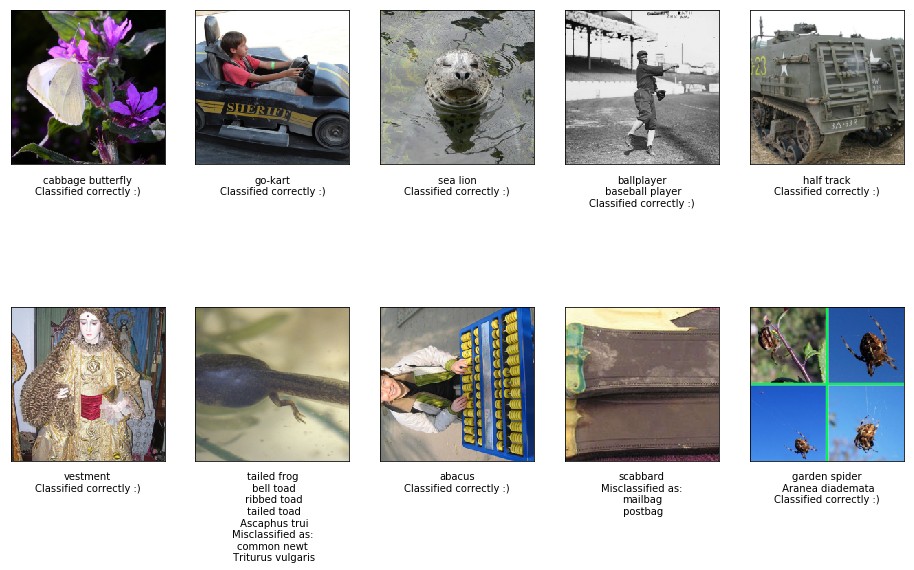

In [8]:
ilsvrc = ILSVRC2014Sample(40)
vgg.eval()

figsize(16, 10)
for i in range(10):
    img = ilsvrc.data[30 + i]
    label = ilsvrc.labels[30 + i]
    
    img_torch = to_variable(img, volatile=True)
    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    
    desc = ilsvrc.label_to_desc[label].split(',')
    if label == predicted_label:
        desc.append('Classified correctly :)')
    else:
        desc.append('Misclassified as:')
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(','))
    
    ax = subplot(2, 5, 1 + i)
    ax.set_xlabel('\n'.join(desc)) #, {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis='both', which='both', bottom='off', left='off', top='off')
    imshow(img)

## Implement classification of your own images below [1p]



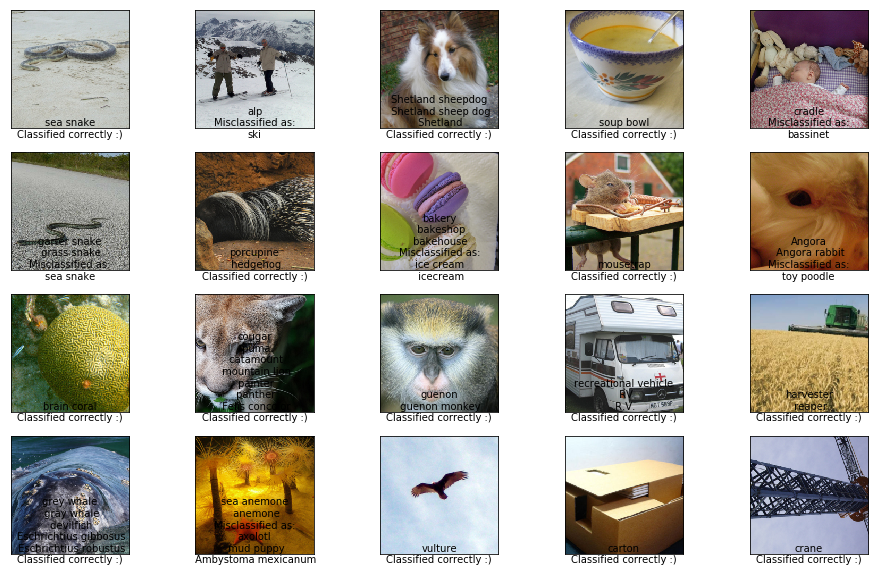

In [9]:
figsize(16, 10)
for i in range(20):
    img = ilsvrc.data[i]
    label = ilsvrc.labels[i]
    
    img_torch = to_variable(img, volatile=True)
    predicted_label_id = to_np(vgg.predict(img_torch))[0]
    predicted_label = ilsvrc.id_to_label[predicted_label_id]
    
    desc = ilsvrc.label_to_desc[label].split(',')
    if label == predicted_label:
        desc.append('Classified correctly :)')
    else:
        desc.append('Misclassified as:')
        desc.extend(ilsvrc.label_to_desc[predicted_label].split(','))
    
    ax = subplot(4, 5, 1 + i)
    ax.set_xlabel('\n'.join(desc), {'verticalalignment': 'bottom'})
    ax.set_xticklabels([], visible=False)
    ax.set_yticklabels([], visible=False)
    ax.tick_params(axis='both', which='both', bottom='off', left='off', top='off')
    imshow(img)

# Problem 3: A Neural Algorithm of Style [3p]

In 2015, Gatys et al. published [A Neural Algorithm of Style](https://arxiv.org/abs/1508.06576),
in which they demonstrates how to
generate images which preserve content of one one source image,
and the style of the other one. This allows to "transfer style",
e.g., from famous paintings to pictures taken with a digital camera.

Style transfer uses a pre-trained image recognition model.
Input image, initialized to random noise, is optimized in such a way,
so that patterns of activations in certain layers would match both
those of style and content. Weights of the network remain frozen,
as only the input image is being changed (through backpropagation).

Using pre-trained a VGG model, implement the artistic algotihm of style.
Begin by adding to the `VGG` class a function 

  `multi_layer_activations(x, layer_names)` .

It should take a list of layer names and input `x` as input, and return activations in those layers. Make sure   the function does it during a single forward pass.

Then:
* **[2p]** complete the code for style transfer and generate new, interesting images,
* **[1p]** by ommiting content loss generate textures based on input style paintings.

In [9]:
img_dir = os.path.join(os.environ['PYTORCH_DATA_PATH'], 'images')

In [10]:
!ls $img_dir

brad_pitt.jpg	      picasso_selfport1907.jpg	starry_night_google.jpg
escher_sphere.jpg     seated-nude.jpg		the_scream.jpg
frida_kahlo.jpg       shipwreck.jpg		tubingen.jpg
golden_gate.jpg       starry_night.jpg		woman-with-hat-matisse.jpg
hoovertowernight.jpg  starry_night_crop.png


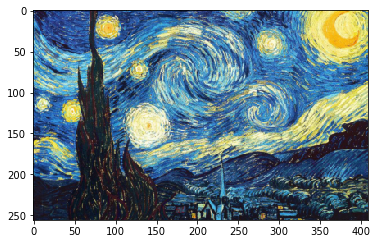

In [11]:
def load_image(path, size=256):
        img = PIL.Image.open(path)
        img = img.convert('RGB')
        img = torchvision.transforms.Scale(size)(img)
        return numpy.asarray(img).astype('float32') / 255.0

imshow(load_image(img_dir + '/starry_night.jpg'))

In [29]:
class StyleTransferNet(object):
    def __init__(self, style_layers, content_layers, vgg_model='vgg19',
                 content_weight=5e0, style_weight=1e2):
        self.style_layers = style_layers
        self.style_captures = []
        self.style_weight = style_weight
        self.content_layers = content_layers
        self.content_captures = []
        self.content_weight = content_weight
        self.vgg = VGG(vgg_model)
        self.vgg.eval()
        for p in self.vgg.parameters():
            p.requires_grad = False
        self.mse = nn.MSELoss()
        
    def capture_content(self, x):
        # TODO
        # implement saving naural activations for a chosen set of content layers
        content_layers = self.vgg.multi_layer_activations(x, self.content_layers)
        self.content_captures = [l for l in content_layers]
        
    def capture_style(self, x):
        style_layers = self.vgg.multi_layer_activations(x, self.style_layers)
        self.style_captures = [self._gram_mat(l) for l in style_layers]

    def get_loss(self, x):
        needed_layers = self.content_layers + self.style_layers
        needed_values = self.vgg.multi_layer_activations(
            x, needed_layers)
        content_values = needed_values[:len(self.content_layers)]
        style_values = needed_values[len(self.content_layers):]
        
        self.content_losses = []
        self.style_losses = []
        
        self.content_losses = [self.mse(x, y) for x,y in zip(content_values, self.content_captures)]
        self.style_losses = [self.mse(self._gram_mat(x), y) for x,y in zip(style_values, self.style_captures)]
        
        loss = sum(self.content_losses) * self.content_weight
        loss += sum(self.style_losses) * self.style_weight
        
        print('losss: ', loss)
        
        return loss
        
        
#     def get_loss(self, x):
        
#         #print('len(self.content_layers): ', len(self.content_layers))
        
#         needed_layers = self.content_layers + self.style_layers
#         needed_values = self.vgg.multi_layer_activations(x, needed_layers)
#         content_values = needed_values[:len(self.content_layers)]
#         style_values = needed_values[len(self.content_layers):]
        
#         #print('len(needed_values): ', len(needed_values))
#         #print('style_values: ', style_values)
        
        
        
#         self.content_losses = []
#         self.style_losses = []
        
#         # TODO:
#         # append onto the lists  self.content_losses and self.style_losses 
#         # the L2 (euclidean) distances between the captured statistics and the 
#         # reconstructed image's ones. Remember about applying the gram matrix to style!
#         # You can use the self.mse to compute the L2 distance
        
#         #print('(x): ', x)
#         #print('self.content_captures: ', self.content_captures)
#         #print('self.style_captures: ', self.style_captures)
#         #print('style_values): ', style_values)
        
#         self.capture_content(x)
#         self.capture_style(x)
        
#         self.content_losses = [self.mse(x, y) for x,y in zip(content_values, self.content_captures)]
#         self.style_losses = [self.mse(self._gram_mat(x), self._gram_mat(y)) for x,y in zip(style_values, self.style_captures)]
        
# #         for i in range(len(content_values)):
# #             self.content_losses += [self.mse(torch.autograd.Variable(self.content_captures[i]), torch.autograd.Variable(content_values[i]))]
            
# #         for i in range(len(style_values)):
# #             self.style_losses += [self.mse(torch.autograd.Variable(self._gram_mat(self.style_captures[i])), self._gram_mat(torch.autograd.Variable(style_values[i])))]
        
        
#         loss = sum(self.content_losses) * self.content_weight
#         loss += sum(self.style_losses) * self.style_weight
        
#         return loss
            
    def _gram_mat(self, x):
        
        """
        Compute the matrix of feature correlations.
        
        Input:
            x: tensor of size batch_size x num_channels x width x heigth
        
        Output:
            tensor of size batch_size x num_chanels x num_channels given by the formula
            
            out[b, c1, c2] = 1/width 1/heigth \sum_w=1^width \sum_h=1^heigth x[b, c1, w, h] * x[b, c2, w, h]
        """
        # TODO
        # Compute the Gram matrix, as defined in the docstring. Try to implement it as efficiently as possible.
        #out[b, c1, c2] = 1/width 1/heigth \sum_w=1^width \sum_h=1^heigth x[b, c1, w, h] * x[b, c2, w, h]
        
#         out = np.dot(x, x.T)
        #print('second dim: ', x.size(1))
        width = x.size(2)
        #print('width: ', width)
        height = x.size(3)
        #print('height: ', height)
        #print('xsize0: ', x.size())
        dim0 = x.size(0)
        #print('dim0: ', dim0)
        dim1 = x.size(1)
        #print('dim1: ', dim1)
        x = x.view(dim0*dim1,width*height)
        #print('xsize1: ', x.size())
        x = x.transpose(0,1)
        #print('xsize2: ', x.size())
        #x = x.view(width*height, dim0, dim1)
        #print('xsize3: ', x.size())
        suma = torch.matmul(x[:].transpose(0,1), x[:])
        #print(suma.size())
        
        out = suma / (double(1)*width*height)
        
#         a, b, c, d = input.size()
#         features = input.view(a * b, c * d)
#         G = torch.mm(features, features.t())
#         return G.div(a * b * c * d)
        return out

In [30]:
# TODO find a giid set of layers for the content and style images.
style_ls =  ["conv1_1", "conv1_2", "conv3_1", "conv4_3"]

content_ls = ["conv3_1", "conv5_1"]

model = StyleTransferNet(
    style_layers=style_ls,
    content_layers=content_ls, content_weight=10e0)

if CUDA:
    model.vgg.cuda()
    
#print(vgg.features)

In [31]:
style_img_path = img_dir + '/starry_night.jpg'
content_img_path = img_dir + '/golden_gate.jpg'

style_img_size = 256
content_img_size = 256

style_image = load_image(style_img_path, style_img_size)
content_image = load_image(content_img_path, content_img_size)
content_shape = content_image.shape

print 'Capturing content'
model.capture_content(to_variable(content_image))

print 'Capturing style'
model.capture_style(to_variable(style_image))

Capturing content
Capturing style


In [34]:
# image = load_image(content_img_path, 512)
image = np.random.randn(*content_shape).astype(np.float32) * 0.01 + 0.5
image = to_variable(image, requires_grad=True)

# try using Adam or LBFGS

#optimizer = torch.optim.Adam([image], lr=0.001)  #, momentum=0.5)
optimizer = torch.optim.LBFGS([image])

Iteration     42 | loss 690.3079224


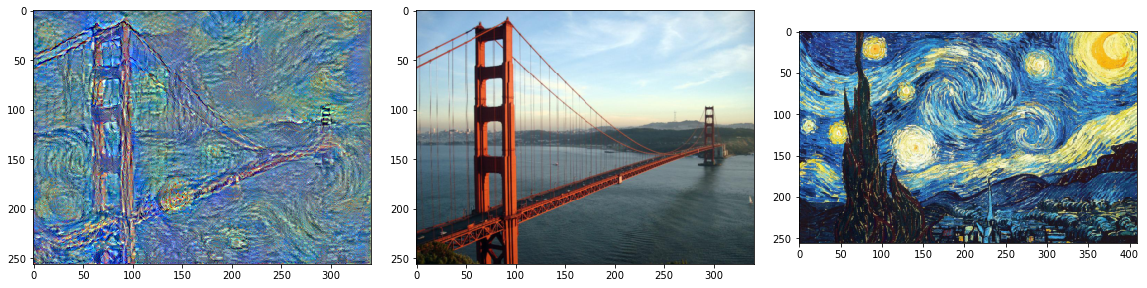

In [35]:
from IPython import display

# Training loop
max_iters = 500
check_every = 5
old_loss = np.inf
tolerance = 0.00001
try:
    fig = figure(figsize=(16, 10))
    fig.add_subplot(132).imshow(content_image)
    fig.add_subplot(133).imshow(style_image)
    ax = fig.add_subplot(131)
    
    tight_layout()
    imsh = ax.imshow(to_np(image));
    for iter_ in range(max_iters):
        
        def closure():
            optimizer.zero_grad()
            loss = model.get_loss(image)
            loss.backward()
            return loss
        
        loss = optimizer.step(closure)
        image.grad.data.zero_()
            
        if iter_ % check_every == 0:
            display.clear_output(wait=True)
            imsh.set_data(np.clip(to_np(image), 0.0, 1.0))
            #ax.imshow(np.clip(to_np(image), 0.0, 1.0))
            display.display(fig)
            
            
            print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.data[0])
            for i, l in enumerate(model.content_losses):
                print '  Content loss {}: {: >8.4f}'.format(i + 1, l.data[0] * model.content_weight)
            for i, l in enumerate(model.style_losses):
                print '  Style loss {}: {: >10.4f}'.format(i + 1, l.data[0] * model.style_weight)
            
        old_loss = loss.data[0]
except KeyboardInterrupt:
    display.clear_output(wait=True)
    print "Iteration {0: >6} | loss {1: >10.7f}".format(iter_, loss.data[0])

# Bonus problems

**[2p]** implement [Google's DeepDream](https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html) using the VGG network and generate more interesting images.

**[2p]** select a few neurons in each layer and try to find images to which the respond the most. Then visualize the gradient with respect to the input pixels at the mostly exciting patches. Try to recreate the figure 2 from M. Zieler Visualizing and Understanding Convolutional Neural Networks (https://arxiv.org/pdf/1311.2901.pdf)